# 02 Extracting a network from an image

An important feature of JellyBaMM is the image analysis toolkit that extracts a network from a tomography image. Here we demonstrate all the steps used to do this task:

In [1]:
import ecm
import matplotlib.pyplot as plt
import numpy as np
import os
import copy

We store some of the saved files into the input directory for future simulations but can turn this feature off

In [2]:
save = False

## Step 1: Average the input images and create a distance transform

In [3]:
os.listdir(ecm.INPUT_DIR)

['0800.tiff',
 'cc_im.npz',
 'im_soft.npz',
 'im_spm_map.npz',
 'im_spm_map_46800.npz',
 'spider_net.pnm',
 '__init__.py']

The first function takes a file directory and averages the images within it returning the image, a minimum half-span of the image and a distance transform of the image to help find the center and perform radial operations. If the file directory is left blank then the `ecm.INPUT_DIR` is used by default.

In [4]:
im, mhs, dt = ecm.average_images()

In [5]:
mhs

875

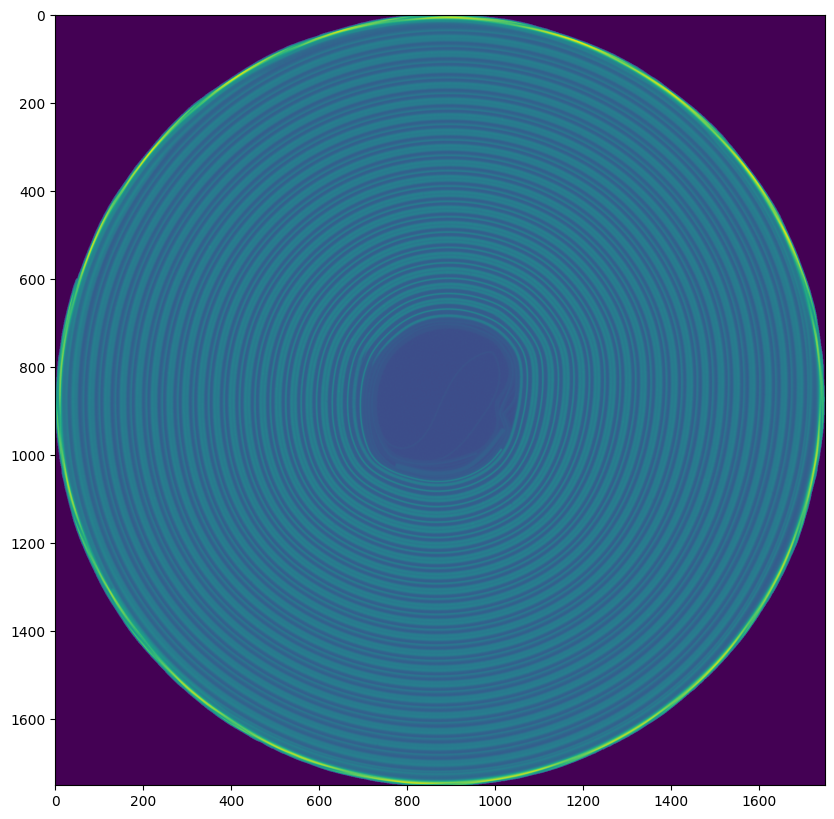

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(im)

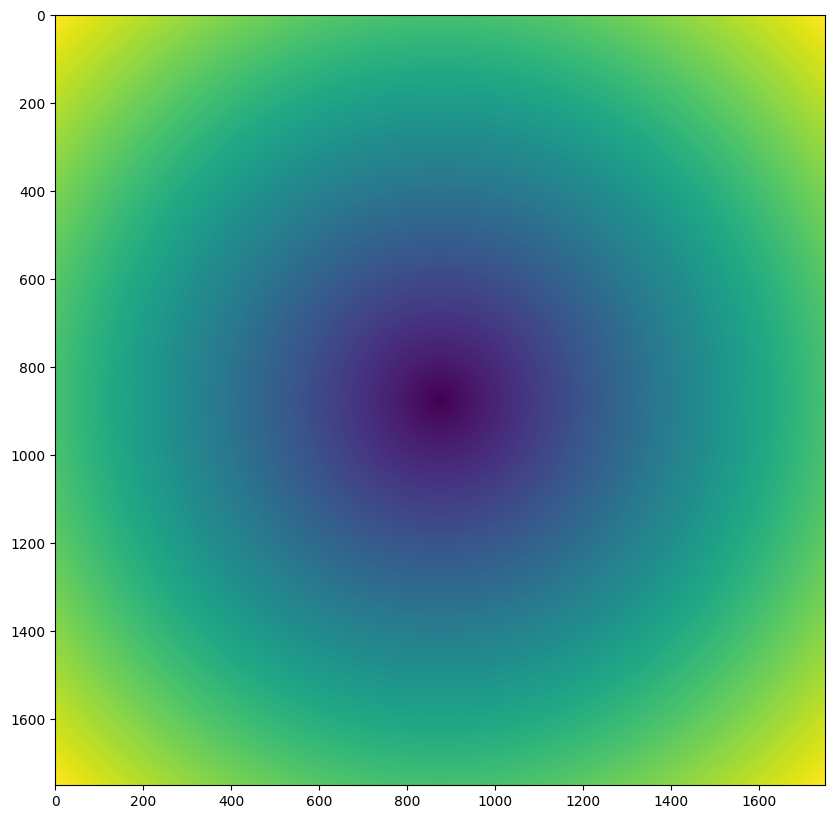

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(dt)

## Step 2: Remove beam hardening

Next remove beam hardening effects by analysing the image using the distance transform to perform raidal binning, averaging and polynomial fitting for the hardening parameter in order to zero it.

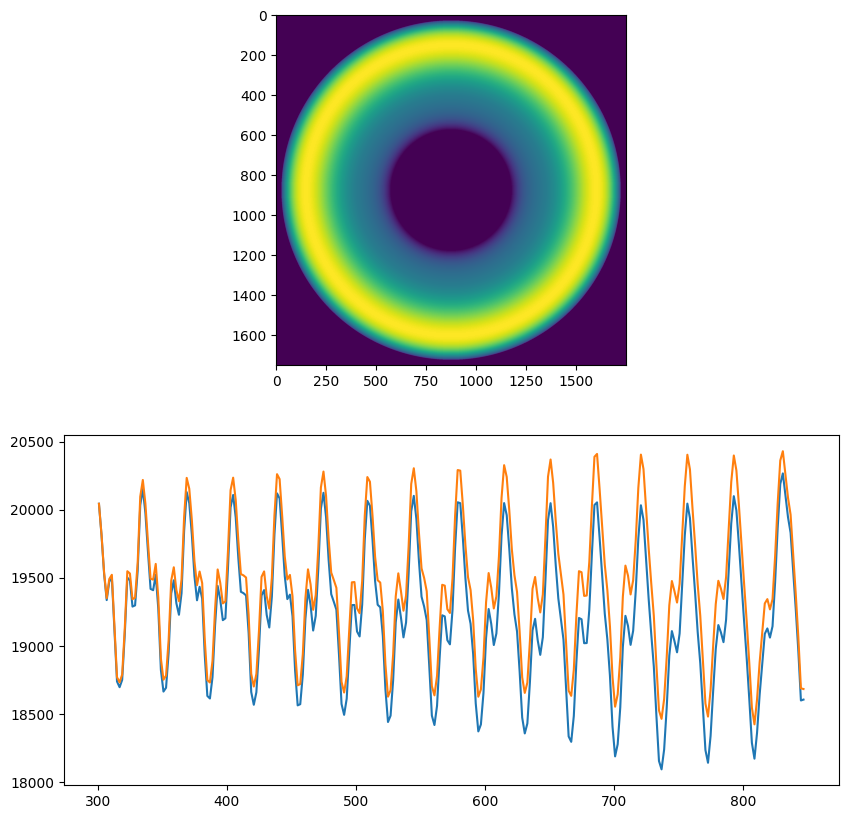

In [8]:
step = 2  # step to take when binning for averaging
deg = 4  # degree of polynomial fitting when fitting intensity profile
im_soft = ecm.remove_beam_hardening(im, dt, step, deg)

In [9]:
img = copy.deepcopy(im_soft)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

# Assuming img is your 2D array image
# For demonstration, create a sample 2D array if you don't have an image
im_low = 10000
im_high = 25000

def plot_image_column_row(column_index, row_index, threshold):
    fig, axes = plt.subplots(2, 2, gridspec_kw={'width_ratios': [5, 1], 'height_ratios': [5, 1]}, figsize=(8,8))
    # Adjust layout
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    # Plot the image
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].axis('off')  # Hide the axis on the image plot
    # Overlay red dotted lines to indicate selected column and row
    axes[0, 0].axvline(x=column_index, color='r', linestyle='--')  # Vertical line for column
    axes[0, 0].axhline(y=row_index, color='r', linestyle='--')  # Horizontal line for row

    
    # Plot the column intensity
    axes[0, 1].plot(img[:, column_index], np.arange(img.shape[0]))
    axes[0, 1].invert_yaxis()  # Invert y-axis to match the image orientation
    axes[0, 1].axvline(x=threshold, color='r', linestyle='--')  # Vertical line for threshold
    axes[0, 1].set_xlim([im_low, im_high])
    axes[0, 1].set_ylim([img.shape[0], 0])
    
    # Plot the row intensity
    axes[1, 0].plot(np.arange(img.shape[1]), img[row_index, :])
    axes[1, 0].axhline(y=threshold, color='r', linestyle='--')  # Vertical line for threshold
    axes[1, 0].set_xlim([0, img.shape[1]])
    axes[1, 0].set_ylim([im_low, im_high])

    # Hide the unused subplot (top right)
    axes[1, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Create interactive widgets for column and row selection
interactive_plot = interactive(plot_image_column_row, column_index=(0, img.shape[1]-1), row_index=(0, img.shape[0]-1), threshold=(im_low, im_high))
output = interactive_plot.children[-1]
output.layout.height = '600px'  # Adjust the layout height
interactive_plot


interactive(children=(IntSlider(value=874, description='column_index', max=1749), IntSlider(value=874, descrip…

The first layer of the jellyroll begins 300 pixels from the center of the image. The blue line is the radially averaged intensity before softening and the orange is after softening.

## Step 3: Label the layers of the image and extract the current collectors

- Using dt we remove any feature with radius greater than the mid-half-span
- Apply a pixel based can_width to any feature within this number of pixels less than the mhs
- Binarize the image using `im_thresh`
- Label the image using `skimage.measure`
- Disregard any labelled regions with area less than the `small_feature_size`
- Skeletonize the remaining labelled regions
- Remove dead ends

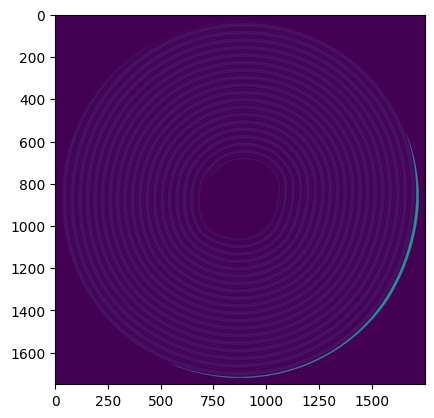

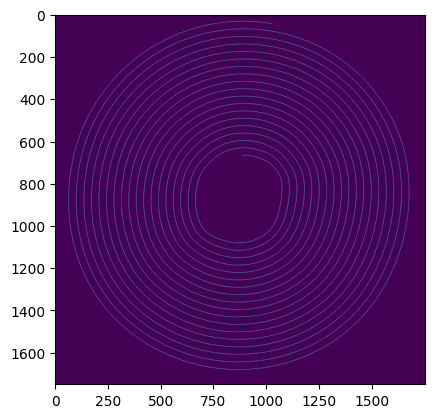

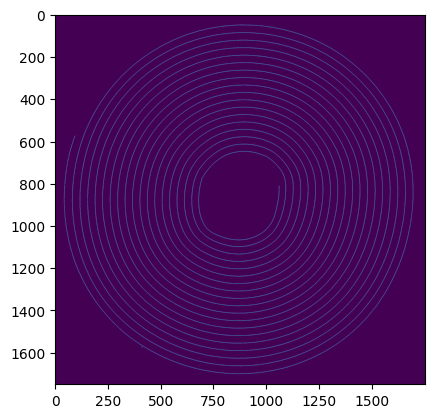

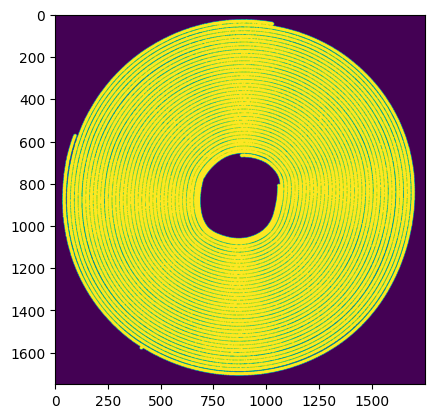

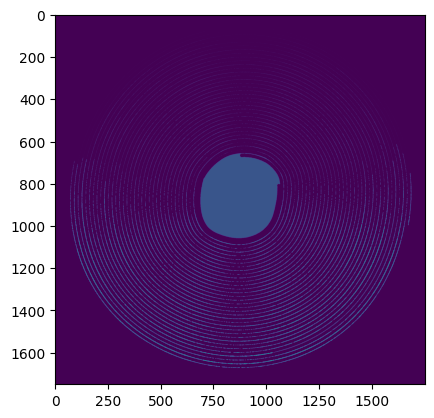

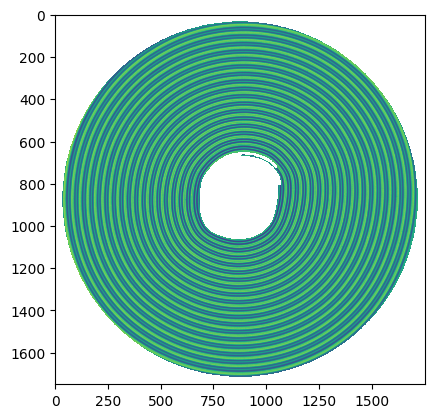

In [11]:
# Label Layers
im_soft, cc_im = ecm.label_layers(im_soft, dt, mhs,
                                  can_width=30,
                                  im_thresh=18000,
                                  small_feature_size=20000)

We now have an image which has highlighted the skeleton of each electrode and identified the current collectors:

In [12]:
np.unique(cc_im)

array([0, 1, 2], dtype=int8)

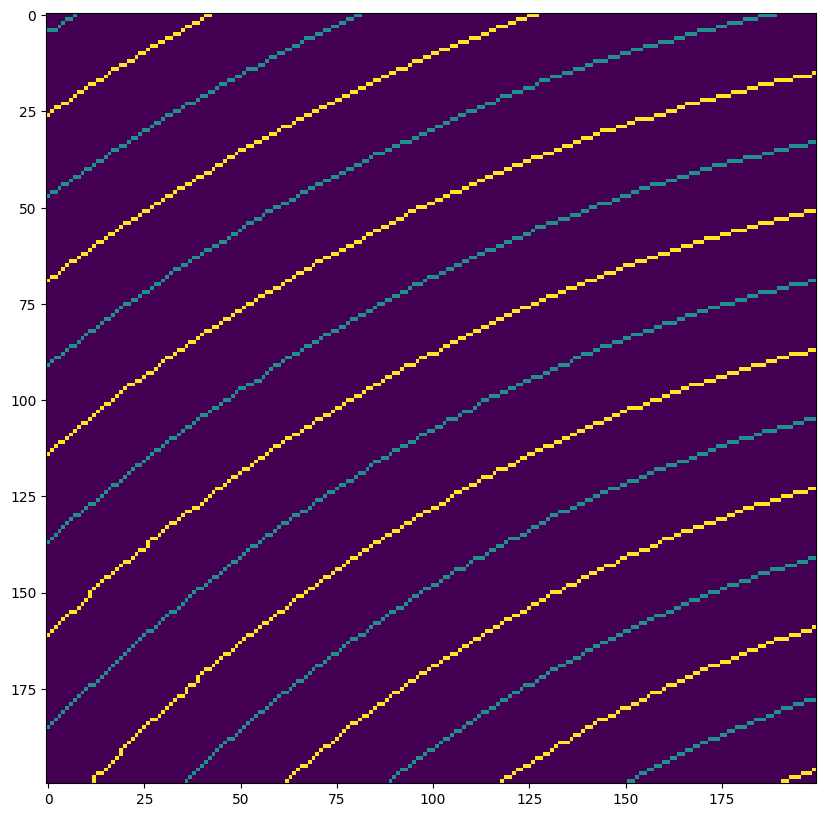

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(cc_im[400:600, 600:800])

## Step 4: Use the images to create the network

Apply a spider web-like node creation algorithm with arc angle between nodes `dtheta` to link current collector nodes as resistors and links between nodes as active battery segments. Once image regions are divided into segments the nodes are labelled and nodal indices are shuffled to order them sequentially with increasing radial distance around the spiral for each electrode.

1319


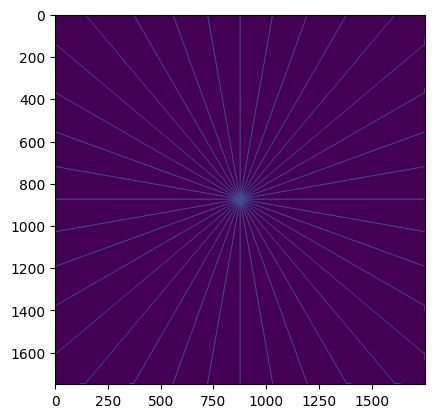

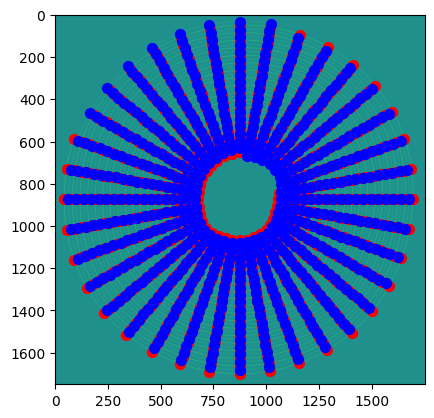

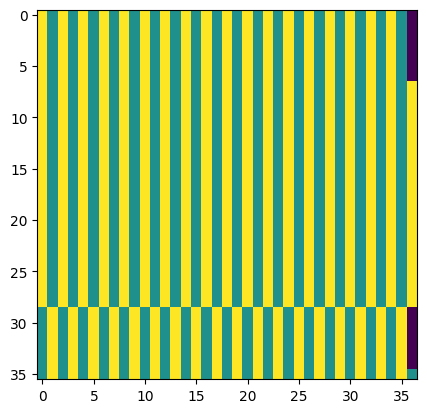

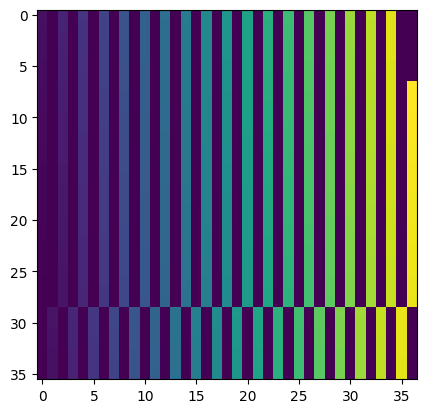

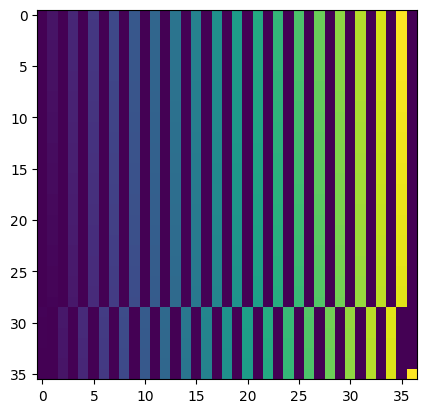

In [14]:
# Make the spider web network
net = ecm.spider_web_network(im_soft, mhs, cc_im, dtheta=10)

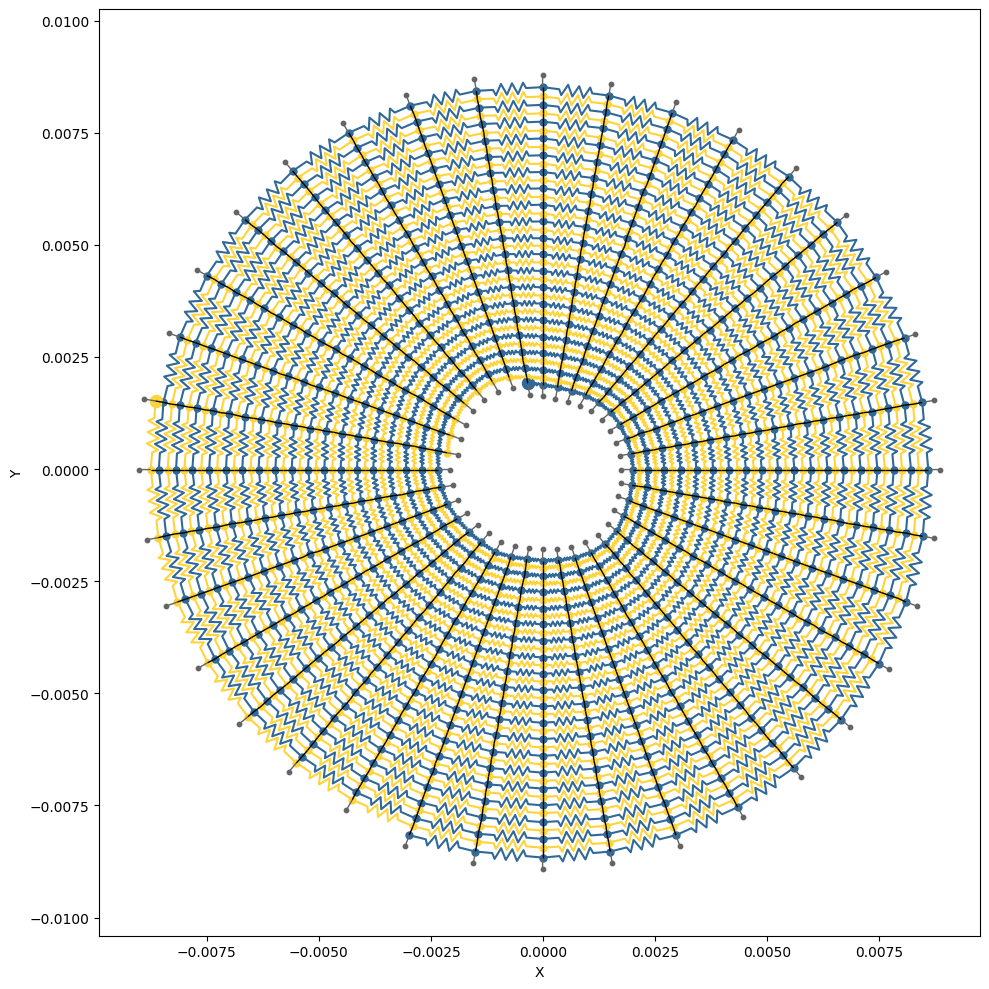

In [15]:
ecm.plot_topology(net)

## Step 5: Apply an interpolation of node index back to the 2D image for post-processing

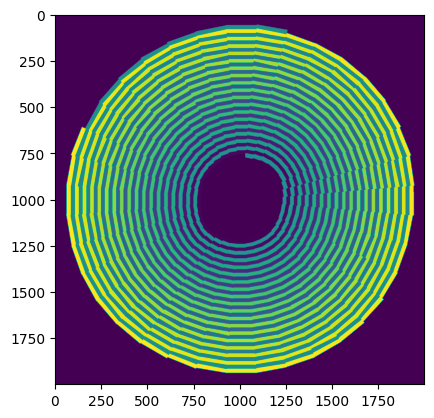

In [16]:
prj = net.project
im_spm_map = ecm.interpolate_spm_number(prj)

In [14]:
if save:
    np.savez(os.path.join(ecm.INPUT_DIR, 'im_soft'), im_soft)
    np.savez(os.path.join(ecm.INPUT_DIR, 'cc_im'), cc_im)
    np.savez(os.path.join(ecm.INPUT_DIR, 'im_spm_map'), im_spm_map)